# **Land Value Prediction Model**
- Author: Kim Dohwan [@ehghks021203](https://github.com/ehghks021203)
- Date: 2023.09.10. ~
- Description: Land value prediction model with XGBoost.
------

## **Overview**
이 프로젝트는 회귀 예측 모델인 XGBoost를 사용하여 토지의 실거래가를 예측하는 모델을 만들고, 


### Key Steps:
**1. Load libraries & get data:**

**2. Data Analysis:**
- 학습에 사용될 데이터셋에 대해 데이터 분석을 진행합니다.
- 연속형 변수와 범주형 변수로 나누어 분석을 진행하였습니다.

**3. Data Preprocessing:**
- 결측치 및 이상치를 제거하고, 범주형 변수에 대한 전처리를 진행하고, 연속형 변수에 대한 스케일링을 진행합니다.

**4. Model Training with XGBoost:**
- XGBoost 알고리즘을 사용하여 가격 예측 모델을 학습합니다.

**5. Evaluation and Validation:**
- 생성된 모델의 성능을 평균절대오차(MAE)와 평균제곱근오차(RMSE)를 사용하여 평가합니다.

**6. Hyperparameter Tuning:**
- 모델의 하이퍼파라미터를 튜닝합니다.
- 튜닝에는 GridSearch, RandomSerch 등의 기법을 사용합니다.

## **1. Load libraries & get data**
### **1-1. Load libraries**
시각화를 위한 matplotlib, seaborn, 데이터 분석을 위한 scipy, 모델 학습을 위한 xgboost 등 필요한 모듈을 임포트 합니다.

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from config import BASE_DIR

# progress bar
import tqdm
from tqdm import trange, notebook

# linear algebra
import numpy as np 

# data processing
import pandas as pd
pd.options.display.float_format = "{: .2f}".format

# data visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set(style="white", context="notebook", palette="deep")

# preprocessing
from sklearn.model_selection import train_test_split

# data analysis
from scipy.stats import kstest
from scipy.stats import skew, norm

# model
import xgboost as xgb

# model visualization
from xgboost import plot_importance
from pdpbox import info_plots

# model validation
from sklearn.metrics import mean_squared_error

# ignore warning
import warnings
warnings.filterwarnings('ignore')

### **1-2. Load datasets**

학습에 사용할 데이터셋을 불러옵니다.

데이터셋의 구성은 다음과 같습니다.

- 토지특성정보
    - PNU: 토지 고유 코드
    - Year: 거래년도
    - Month: 거래월
    - Price: 거래가격
    - DealArea: 거래면적
    - PblntfPclnd: 공시지가
    - RegstrSe: 필지
    - Lndcgr: 지목
    - LndpclAr: 면적
    - PrposArea1: 용도지역1
    - PrposArea2: 용도지역2
    - LadUseSittn: 이용상황
    - TpgrphHg: 지세
    - TpgrphFrm: 형상
    - RoadSide: 도로접면
- 토지 이용계획
    - LandUsePlans: 토지 이용계획
- 토지 지가변동률
    - PclndIndex: 지가지수
    - PclndChgRt: 지가변동률
    - AcmtlPclndChgRt: 누계지가변동률
    - LargeClPclndIndex: 권역별 지가지수
    - LargeClPclndChgRt: 권역별 지가변동률
    - LargeClAcmtlPclndChgRt: 권역별 누계지가변동률
- 물가지수
    - PPI: 생산자물가지수
    - CPI: 소비자물가지수
- 주변 상권 데이터
    - CTG: 가장 가까운 CTG 상권과의 거리
    - CTG_500m: 500m 이내에 있는 CTG 상권 수
    - CTG_1000m: 1000m 이내에 있는 CTG 상권 수
    - CTG_3000M: 3000m 이내에 있는 CTG 상권 수

카테고리(CTG)는 아래와 같습니다:

|항목|설명|항목|설명|
|:---:|:---|:---:|:---|
|MT1|대형마트|CT1|문화시설|
|CS2|편의점|AG2|중개업소|
|PS3|어린이집 및 유치원|PO3|공공기관|
|SC4|학교|AT4|관광명소|
|AC5|학원|AD5|숙박|
|PK6|주차장|FD6|음식점|
|OL7|주유소 및 충전소|CE7|카페|
|SW8|지하철역|HP8|병원|
|BK9|은행|PM9|약국|


In [2]:
# Load Train Dataset
# DATA_PATH = BASE_DIR + "/Data/DatasetWithoutCdData.csv"
DATA_PATH = BASE_DIR + "/Data/Dataset.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
# PNU 코드 자료형을 문자열로 변경
df["PNU"] = df["PNU"].astype("str")

# PNU 코드 중 시/도 추출
df.insert(loc=1,column="Sido",value=df["PNU"].str.slice(0, 2).astype("object"))
df.insert(loc=2,column="LdCode",value=df["PNU"].str.slice(0, 10).astype("object"))

# PNU 코드, 법정동 코드, 거래 면적 feature 제거
df.drop(["PNU", "LdCode", "DealArea"], axis=1, inplace=True)

## **2. Data analysis**
### **2-1. target feature(거래가)에 대한 분석**

우리가 예측하고자 하는 feature인 Price(거래가)에 대한 데이터 분석을 진행합니다. 실제 거래가의 경우 공시지가와 연관이 크기 때문에, 공시지가와 연관지어 데이터 분석을 진행하였습니다.

지역별로 가격 편차가 크기 때문에 로그 스케일링을 하여 시각화 하였습니다.

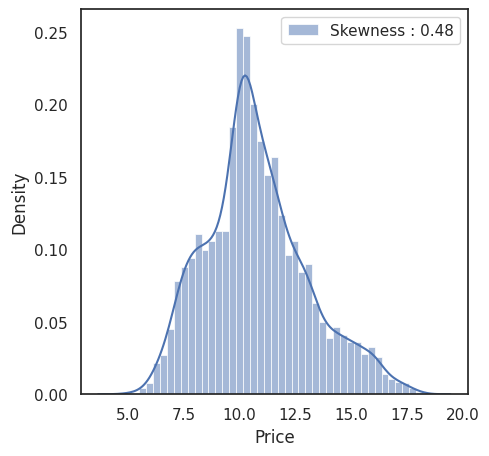

In [4]:
# target frature에 대한 분석
plt.subplots(figsize=(5, 5))
g = sns.histplot(
    np.log1p(df["Price"]),   # 가격 편차가 크기 때문에 log scaling을 해줌
    kde=True,
    stat="density",
    kde_kws=dict(cut=3),
    label = "Skewness : %.2f"%(np.log1p(df["Price"]).skew())
)
g = g.legend(loc="best")

<Axes: ylabel='Price'>

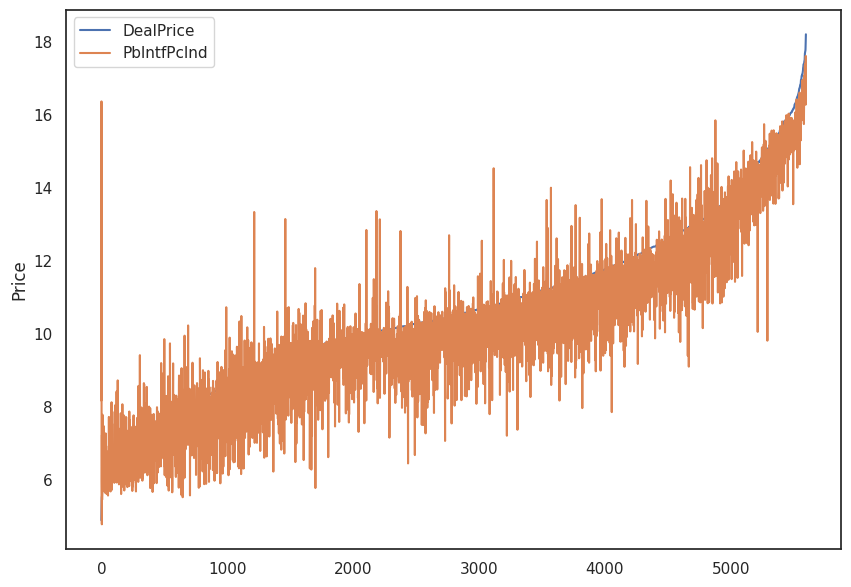

In [5]:
df_price = df[["Price", "PblntfPclnd"]]
df_price = df_price.sort_values("Price").reset_index(drop=True)

plt.subplots(figsize=(10, 7))
sns.lineplot(np.log1p(df_price["Price"]), label="DealPrice")
sns.lineplot(np.log1p(df_price["PblntfPclnd"]), label="PblntfPclnd")

실제 거래가와 공시지가 가격의 격차가 심한 모습을 확인할 수 있습니다. 격차가 매우 심한 데이터의 경우 이상치로 간주할 수 있습니다.

<br/>

### **2-2. 연속형 변수에 대한 데이터 분석**

In [6]:
# 연속형 변수에 대한 데이터 분석
numerical = [var for var in df.columns if df[var].dtype!="O"]  # 연속형 변수 추출
print(numerical)

['Year', 'Month', 'Price', 'PblntfPclnd', 'LndpclAr', 'PclndIndex', 'PclndChgRt', 'AcmtlPclndChgRt', 'LargeClPclndIndex', 'LargeClPclndChgRt', 'LargeClAcmtlPclndChgRt', 'PPI', 'CPI', 'MT1', 'MT1_500m', 'MT1_1000m', 'MT1_3000m', 'CS2', 'CS2_500m', 'CS2_1000m', 'CS2_3000m', 'PS3', 'PS3_500m', 'PS3_1000m', 'PS3_3000m', 'SC4', 'SC4_500m', 'SC4_1000m', 'SC4_3000m', 'AC5', 'AC5_500m', 'AC5_1000m', 'AC5_3000m', 'PK6', 'PK6_500m', 'PK6_1000m', 'PK6_3000m', 'OL7', 'OL7_500m', 'OL7_1000m', 'OL7_3000m', 'SW8', 'SW8_500m', 'SW8_1000m', 'SW8_3000m', 'BK9', 'BK9_500m', 'BK9_1000m', 'BK9_3000m', 'CT1', 'CT1_500m', 'CT1_1000m', 'CT1_3000m', 'AG2', 'AG2_500m', 'AG2_1000m', 'AG2_3000m', 'PO3', 'PO3_500m', 'PO3_1000m', 'PO3_3000m', 'AT4', 'AT4_500m', 'AT4_1000m', 'AT4_3000m', 'AD5', 'AD5_500m', 'AD5_1000m', 'AD5_3000m', 'FD6', 'FD6_500m', 'FD6_1000m', 'FD6_3000m', 'CE7', 'CE7_500m', 'CE7_1000m', 'CE7_3000m', 'HP8', 'HP8_500m', 'HP8_1000m', 'HP8_3000m', 'PM9', 'PM9_500m', 'PM9_1000m', 'PM9_3000m']


연속형 변수에 대한 분석은 상관계수 히트맵을 그려 진행하였습니다.

<Axes: >

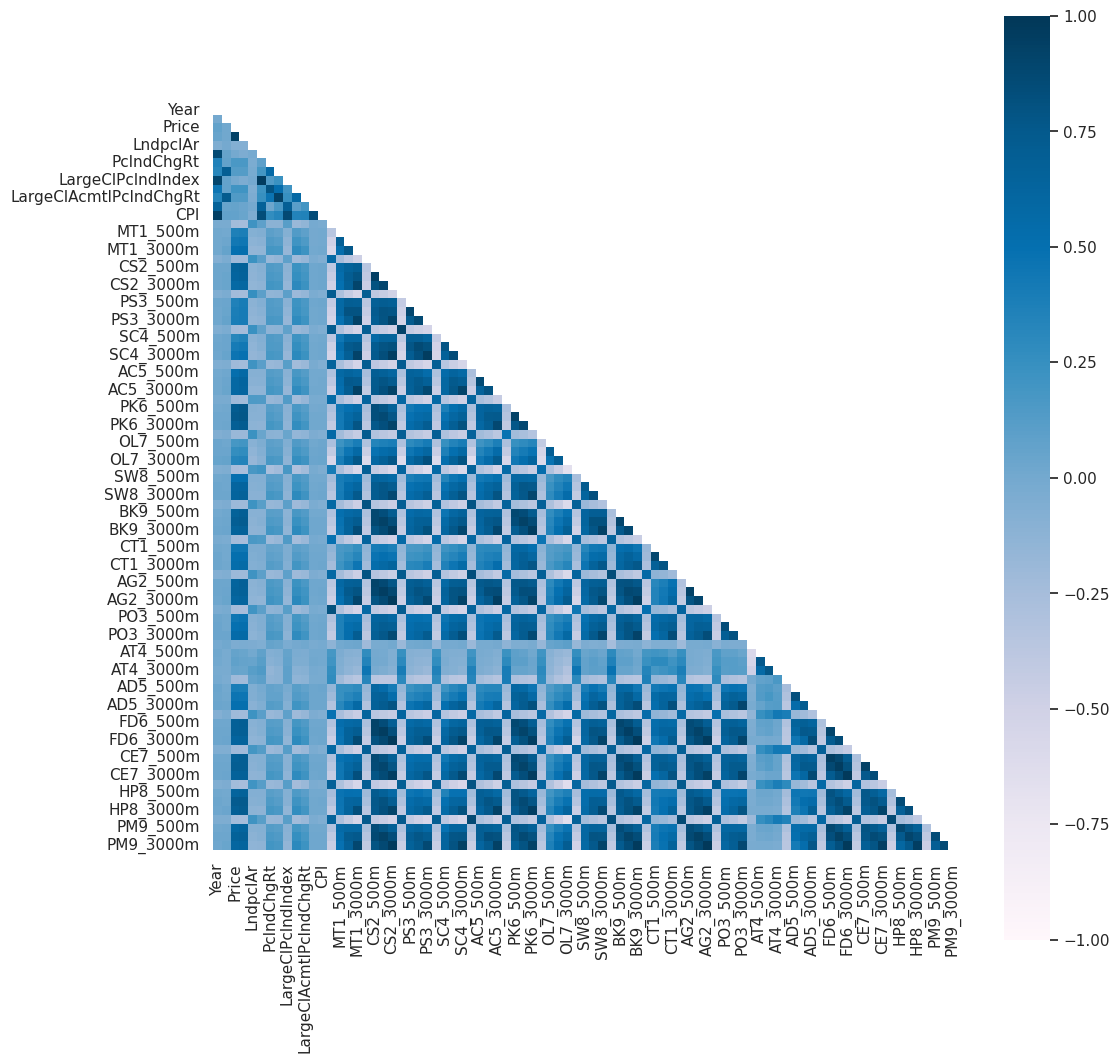

In [7]:
corr = df[numerical].corr(method="pearson")
mask_df = corr
colormap = plt.cm.PuBu

mask = np.zeros_like(mask_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr, 
    vmax=1.0,
    vmin=-1.0,
    square=True, 
    mask=mask,
    cmap=colormap, 
    linecolor="white"
)

공시지가(PblntfPclnd)와의 상관계수가 매우 크게 나타나는 것을 알 수 있고, 이 외에 주변 상권 데이터(몇 미터 이내에 상권이 얼마나 존재하는지)와의 상관계수가 높게 나타난 것을 알 수 있습니다.
수치화해서 보면 다음과 같습니다.

In [8]:
corr["Price"][corr["Price"].values > 0.5].sort_values(ascending=False)

Price          1.00
PblntfPclnd    0.93
PK6_1000m      0.75
HP8_1000m      0.73
PK6_500m       0.72
CE7_1000m      0.70
BK9_1000m      0.70
PK6_3000m      0.69
HP8_3000m      0.69
CE7_500m       0.69
FD6_1000m      0.68
FD6_500m       0.67
BK9_500m       0.66
PM9_1000m      0.66
CE7_3000m      0.65
BK9_3000m      0.65
AG2_1000m      0.64
CS2_500m       0.64
HP8_500m       0.64
SW8_3000m      0.64
AG2_500m       0.63
CS2_1000m      0.63
FD6_3000m      0.63
SW8_1000m      0.62
PM9_3000m      0.62
AG2_3000m      0.61
PM9_500m       0.61
AC5_1000m      0.59
AC5_3000m      0.59
CS2_3000m      0.59
PO3_3000m      0.55
CT1_3000m      0.54
AC5_500m       0.52
CT1_1000m      0.51
SW8_500m       0.51
AD5_3000m      0.51
Name: Price, dtype: float64

### **2-3. 범주형 변수에 대한 분석**

In [9]:
# 범주형 변수에 대한 데이터 분석
categorical = [var for var in df.columns if df[var].dtype=='O']  # 범주형 변수 추출
print(categorical)

['Sido', 'RegstrSe', 'Lndcgr', 'PrposArea1', 'PrposArea2', 'LadUseSittn', 'TpgrphHg', 'TpgrphFrm', 'RoadSide', 'LandUsePlans']


<Axes: xlabel='Sido', ylabel='Price'>

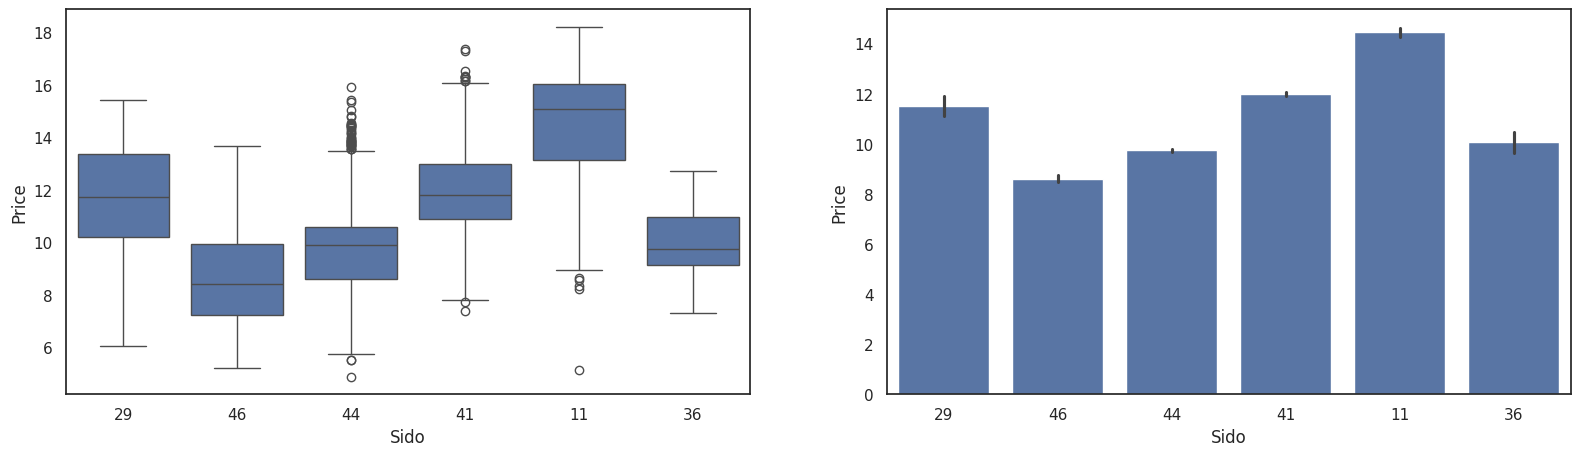

In [10]:
plt.subplots(figsize=(30,5))
plt.clf()
plt.subplot(1, 3, 1)
sns.boxplot(x=df[categorical[0]], y=np.log1p(df["Price"]))
plt.subplot(1, 3, 2)
sns.barplot(x=df[categorical[0]], y=np.log1p(df["Price"]))

위 그래프를 보면 시도별로 가격 차이가 많이 나는 것을 확인할 수 있습니다. 이 외에 다른 데이터에 대한 분석은 `data_analysis.ipynb`에서 확인해 볼 수 있습니다.

## **3. Data preprocessing**
### **3-1. 이상치 제거**
앞서 말했던 대로 공시지가와 가격 차이가 많이 나는 데이터를 이상치로 간주하여 제거하는 작업을 진행해줍니다.

<Axes: xlabel='difference'>

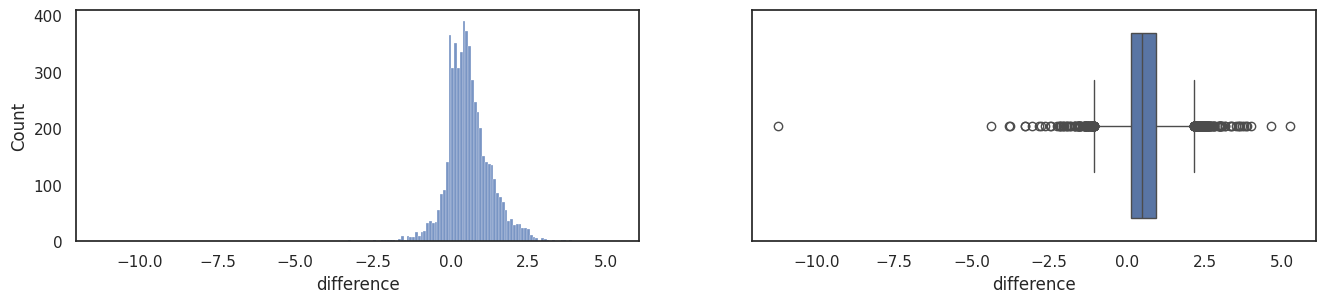

In [11]:
df["difference"] = np.log1p(df["Price"])-np.log1p(df["PblntfPclnd"])

fig, axes = plt.subplots(1, 2, figsize=(16, 3))

sns.histplot(x=df["difference"], ax=axes[0])
sns.boxplot(x=df["difference"], ax=axes[1])

In [12]:
df["difference"].describe()

count    5597.00
mean        0.57
std         0.74
min       -11.24
25%         0.14
50%         0.50
75%         0.94
max         5.25
Name: difference, dtype: float64

1.5*IQR 기법을 통해 이상치 제거를 진행하였습니다.

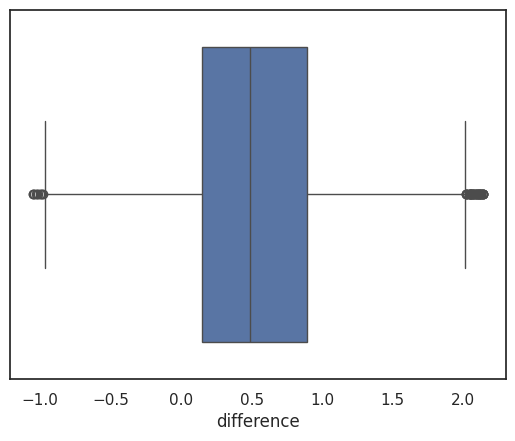

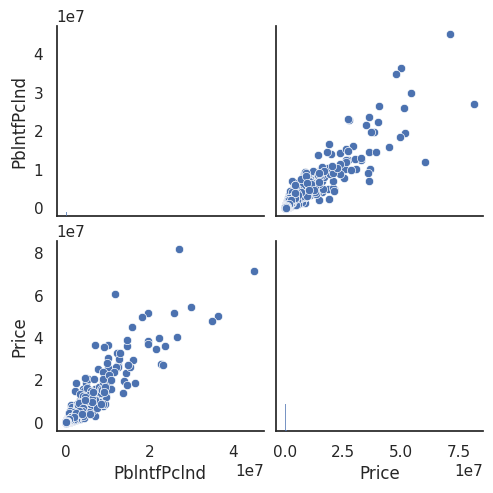

In [13]:
weight = 1.5

quantile_25 = np.percentile(df["difference"].values, 25)
quantile_75 = np.percentile(df["difference"].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df = df[df["difference"].between(lowest, highest)]
sns.boxplot(x=df["difference"])
df = df.drop(["difference"], axis=1)

sns.pairplot(df, vars=["PblntfPclnd", "Price"])
plt.show()

<Axes: ylabel='Price'>

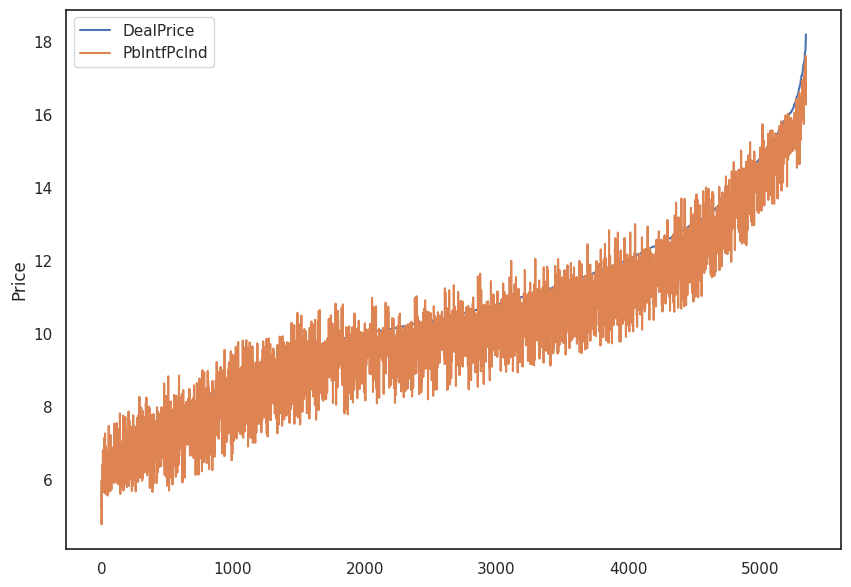

In [14]:
df_price = df[["Price", "PblntfPclnd"]]
df_price = df_price.sort_values("Price").reset_index(drop=True)

plt.subplots(figsize=(10, 7))
sns.lineplot(np.log1p(df_price["Price"]), label="DealPrice")
sns.lineplot(np.log1p(df_price["PblntfPclnd"]), label="PblntfPclnd")

그래프가 안정적으로 바뀐 것을 확인할 수 있습니다.

<br/>

### **3-2. 결측치 제거**
학습 데이터셋에서 값이 누락된 행에 대해 결측치 제거 작업을 진행해 줍니다.

In [15]:
# 결측치 제거
origin_d = df.isnull().sum()  # 결측치 개수 확인
df = df.dropna()
df = df.reset_index(drop=True)
remove_d = df.isnull().sum()  # 결측치 제거 확인
for k in origin_d.keys():
    print("{:26s} | {:6d} -> {:26s} | {:6d}".format(k, origin_d[k], k, remove_d[k]))

Sido                       |      0 -> Sido                       |      0
Year                       |      0 -> Year                       |      0
Month                      |      0 -> Month                      |      0
Price                      |      0 -> Price                      |      0
PblntfPclnd                |      0 -> PblntfPclnd                |      0
RegstrSe                   |      0 -> RegstrSe                   |      0
Lndcgr                     |      0 -> Lndcgr                     |      0
LndpclAr                   |      0 -> LndpclAr                   |      0
PrposArea1                 |      0 -> PrposArea1                 |      0
PrposArea2                 |      0 -> PrposArea2                 |      0
LadUseSittn                |      0 -> LadUseSittn                |      0
TpgrphHg                   |      0 -> TpgrphHg                   |      0
TpgrphFrm                  |      0 -> TpgrphFrm                  |      0
RoadSide                 

### **3-3. 범주형 변수에 대한 One-Hot Encoding**

In [16]:
# 범주형 변수에 대한 One-Hot Encoding
categorical.remove("LandUsePlans")  # 토지 이용 상황은 하나의 cell에 범주 값이 여러개 존재하기 때문에, 다른 방식으로 처리해준다.

df = pd.get_dummies(data=df, columns=categorical)  # One-Hot Encoding

# 토지이용계획에 대한 
land_uses_iter = (set(x.split("/")) for x in df["LandUsePlans"])
land_uses_set = sorted(set.union(*land_uses_iter))
land_uses_mat = pd.DataFrame(np.zeros((len(df), len(land_uses_set))), columns=land_uses_set)
for i in range(len(df)):
    land_uses_mat.loc[i, df["LandUsePlans"][i].split("/")] = 1
df = df.join(land_uses_mat.add_prefix("LandUsePlans_"))
df.drop(["LandUsePlans"], axis=1, inplace=True)
df = df.fillna(0.0)

In [17]:
# Divided train & test dataset
x = df.drop(["Price"], axis=1)
y = df["Price"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 0)
print('Train Dataset:', train_x.shape, '\nTest Dataset:', test_x.shape)

train_y = train_y.to_numpy().astype(int)
test_y = test_y.to_numpy().astype(int)

Train Dataset: (3745, 1006) 
Test Dataset: (1606, 1006)


### **Model Training with XGBoost**

In [18]:


parameter = {
    'learning_rate':0.22,
    'n_estimators':350,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.91,
    'colsample_bytree':0.89,
    'lambda':10,
    'alpha':5,
    'eval_metric':'rmse',
    'seed':0
}
    
model = xgb.XGBRegressor(
    tree_method = "hist",
    device = "cuda",
    importance_type = 'gain',
    learning_rate = parameter['learning_rate'],
    n_estimators = parameter['n_estimators'], 
    max_depth = parameter['max_depth'],
    min_child_weight = parameter['min_child_weight'],
    gamma = parameter['gamma'],
    subsample = parameter['subsample'],
    colsample_bytree = parameter['colsample_bytree'],
    reg_lambda = parameter['lambda'],
    alpha = parameter['alpha'],
    eval_metric = parameter['eval_metric'],
    seed = parameter['seed']
)

model.fit(train_x, train_y)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.89, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.22, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, ...)

In [19]:
len(model.feature_names_in_)

1006

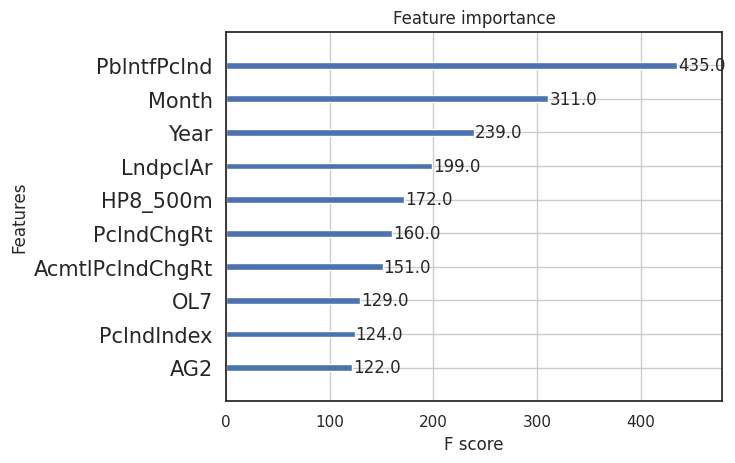

In [20]:
plot_importance(model, max_num_features=10)

plt.yticks(fontsize=15)
plt.show()

### **Evaluation and Validation**

In [21]:
relation_square = model.score(train_x, train_y)
print("R-Squared: ", relation_square)

predict_y = model.predict(test_x)
#predict_y = np.exp(predict_y_log) - 1
#test_y = np.exp(test_y) - 1
result = pd.DataFrame({'pred' : predict_y, 'real' : test_y})
print("RMSE score: {:,.0f}".format(mean_squared_error(test_y, predict_y) ** 0.5))

result['ratio(%)'] = (abs(result['pred'] - result['real']) / result['real']) * 100

R-Squared:  0.9999755725588922
RMSE score: 1,904,161


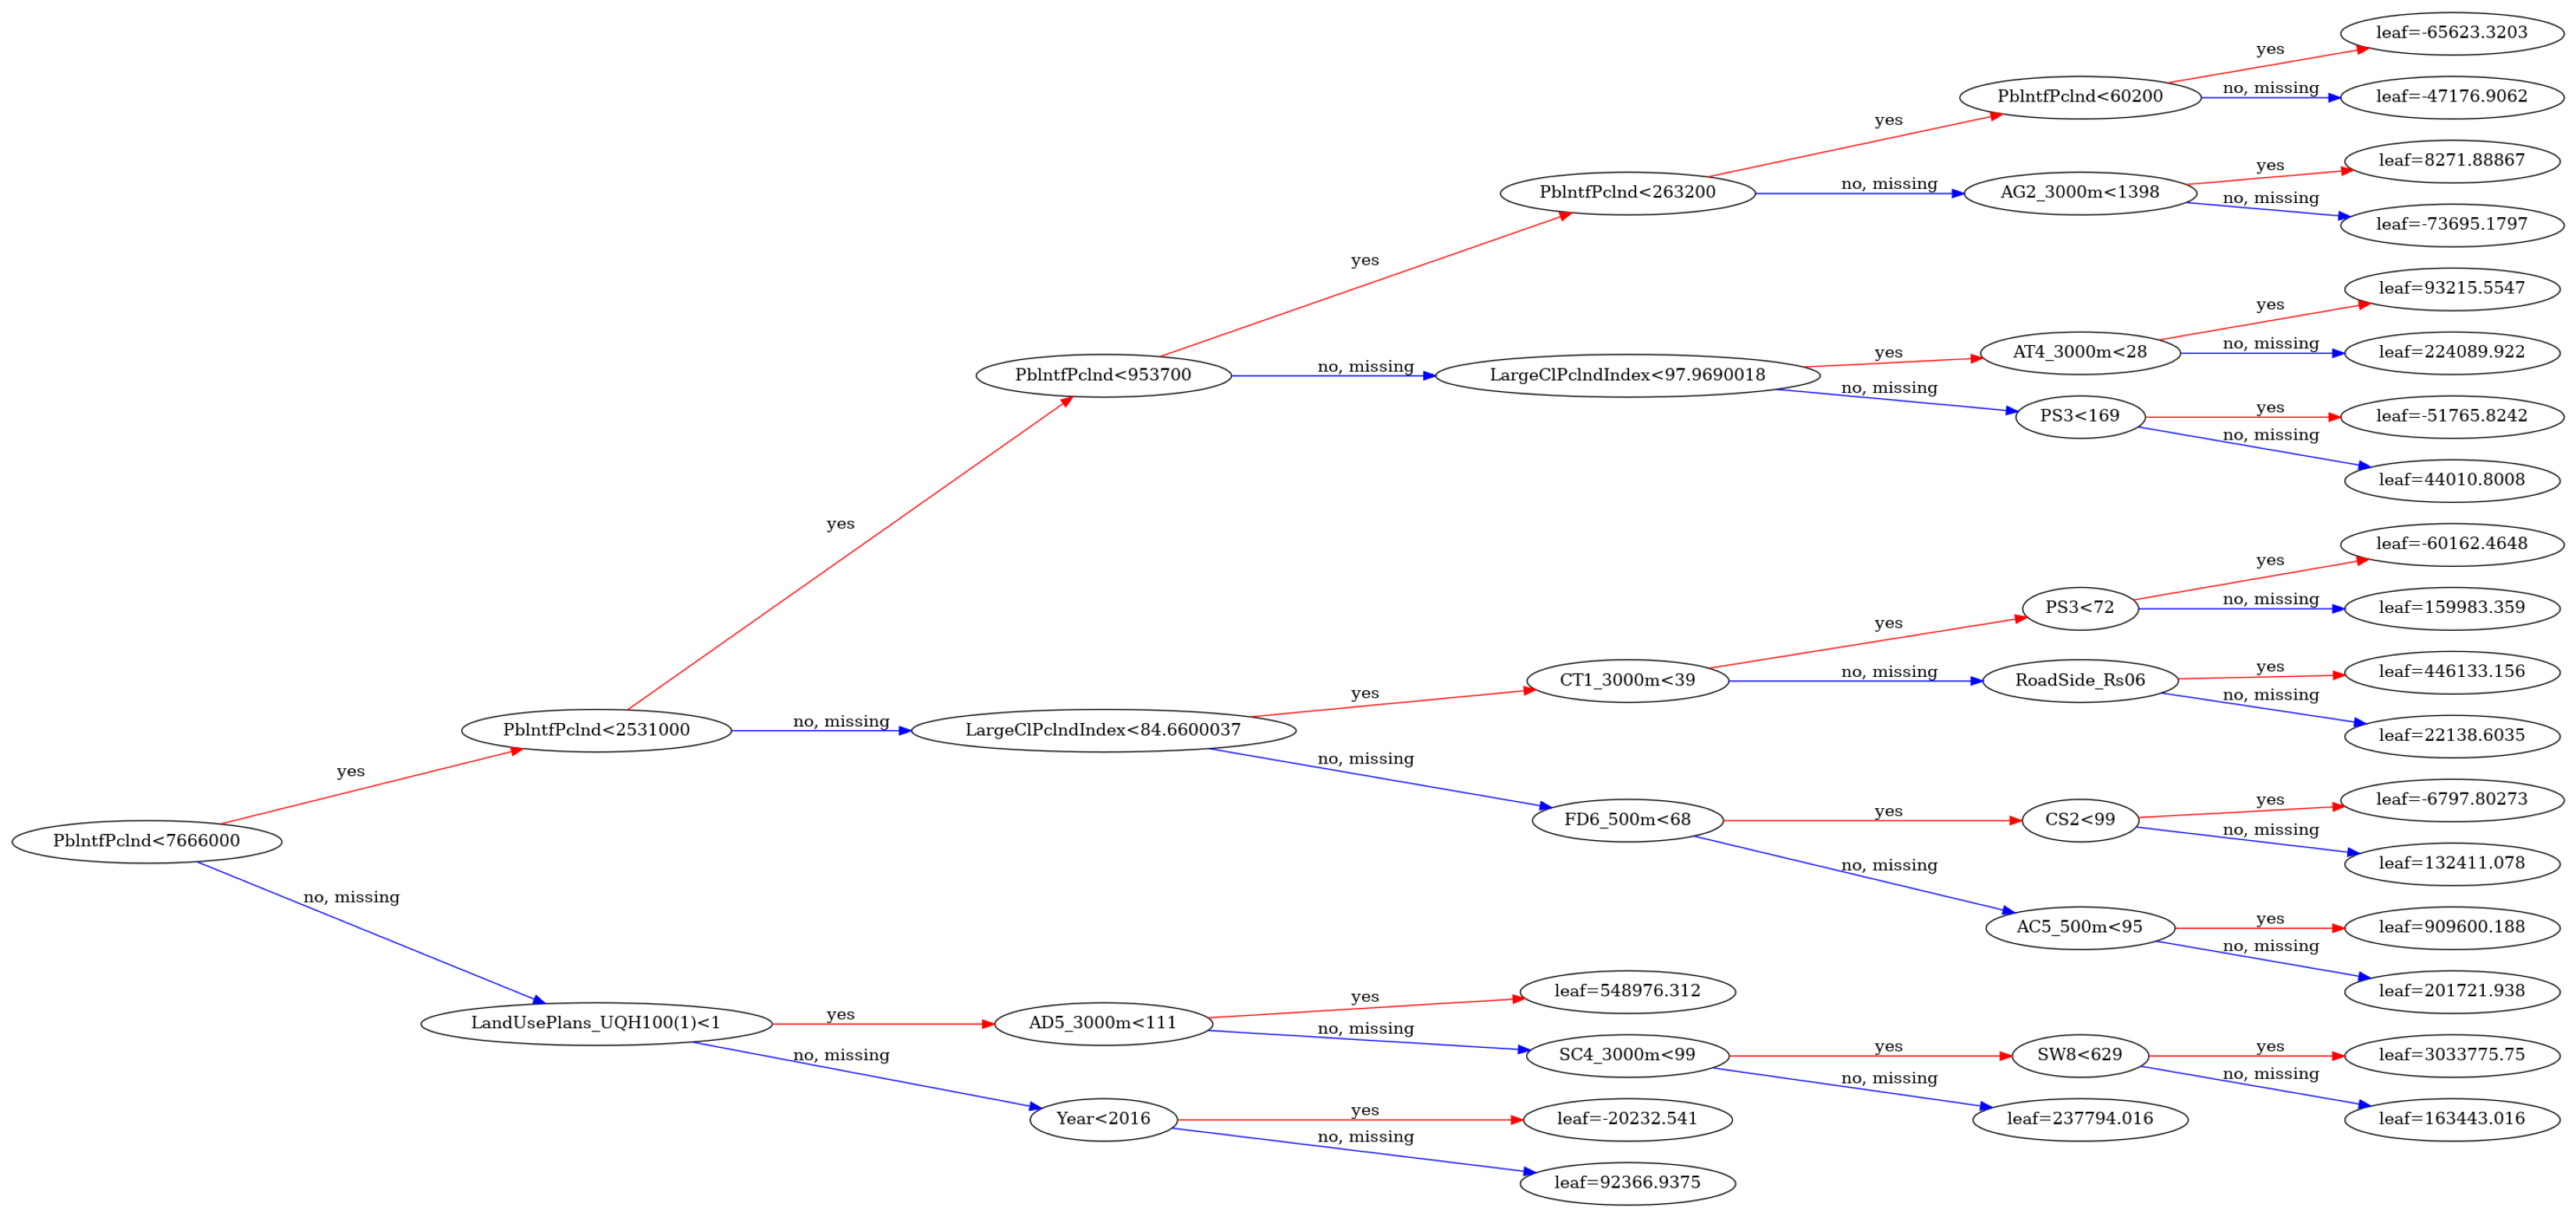

In [22]:
# Model visualization
fig, ax = plt.subplots(figsize=(100, 20))
xgb.plot_tree(model, num_trees=4, rankdir='LR', ax=ax)
plt.show()

In [23]:
print(result.sort_values("ratio(%)"))
for r in [3, 5, 10, 20]:
    print("ratio < {:2d}%: {:5d} / {:5d} ({:4.2f}%)".format(
        r, len(result[result["ratio(%)"] < r]), len(result), len(result[result["ratio(%)"] < r])/len(result)*100
    ))

            pred     real  ratio(%)
1268    16424.38    16457      0.20
590   3485234.25  3492191      0.20
1345   198053.00   197628      0.22
376   3888950.50  3901802      0.33
171    417922.19   420000      0.49
...          ...      ...       ...
746     52630.75     2400   2092.95
1439   410662.91    18144   2163.35
129   -274560.00    10259   2776.28
473    138583.88     4726   2832.37
5      101150.31      254  39722.96

[1606 rows x 3 columns]
ratio <  3%:    57 /  1606 (3.55%)
ratio <  5%:   103 /  1606 (6.41%)
ratio < 10%:   205 /  1606 (12.76%)
ratio < 20%:   396 /  1606 (24.66%)


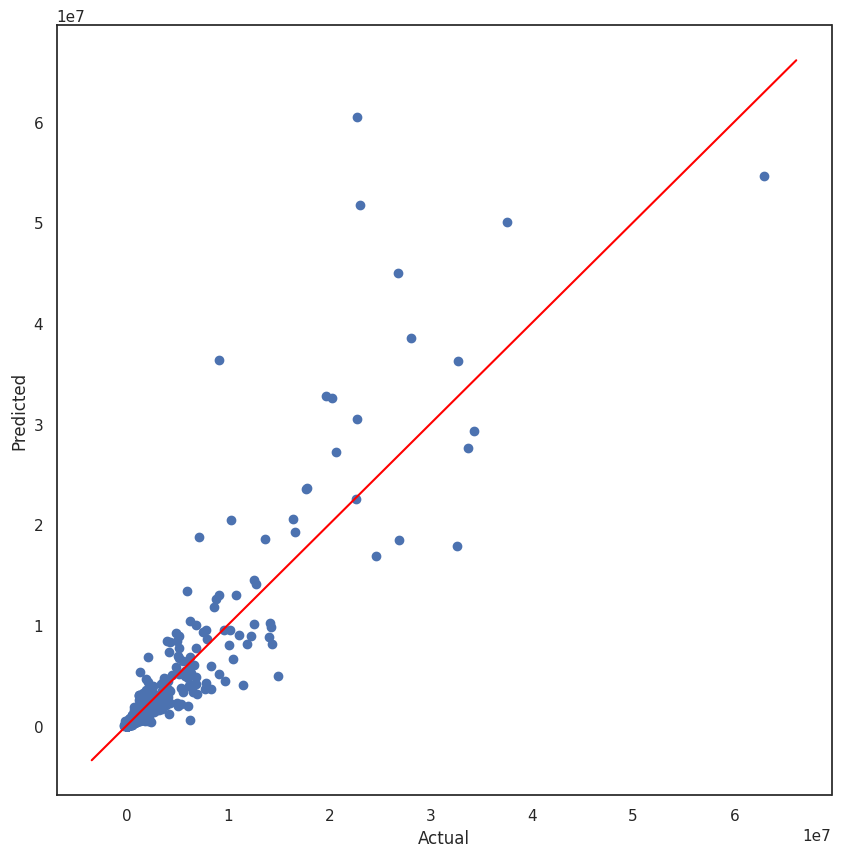

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data=result, x="pred", y="real")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='red')
plt.show()

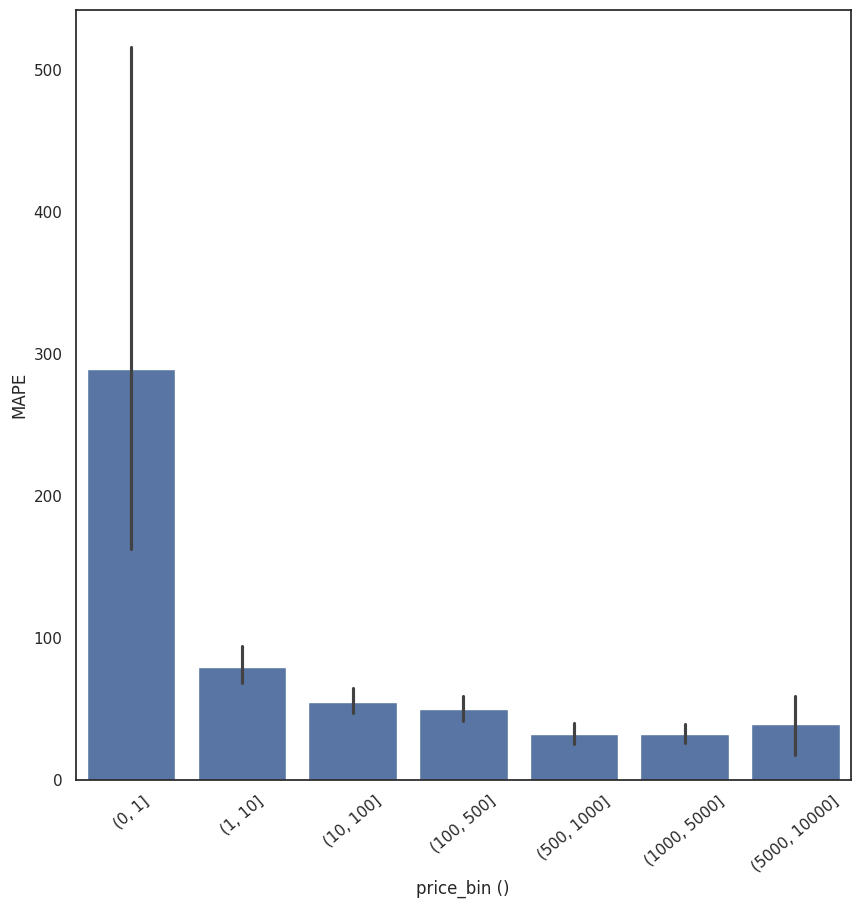

In [25]:
price_bin = pd.cut(test_y/10000,bins=[0,1,10,100,500,1000,5000,10000])
mape = result["ratio(%)"]

fig,ax = plt.subplots(1,figsize=(10,10))
sns.barplot(x=price_bin, y=mape)
ax.set_ylabel('MAPE')
ax.set_xlabel('price_bin ()')
plt.xticks(rotation=40)
plt.show()

In [26]:
price_bin

[(10, 100], (10, 100], (100, 500], (1, 10], (10, 100], ..., (1, 10], (0, 1], (1, 10], (1, 10], (100, 500]]
Length: 1606
Categories (7, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 500] < (500, 1000] < (1000, 5000] < (5000, 10000]]

<Axes: xlabel='ratio(%)', ylabel='Density'>

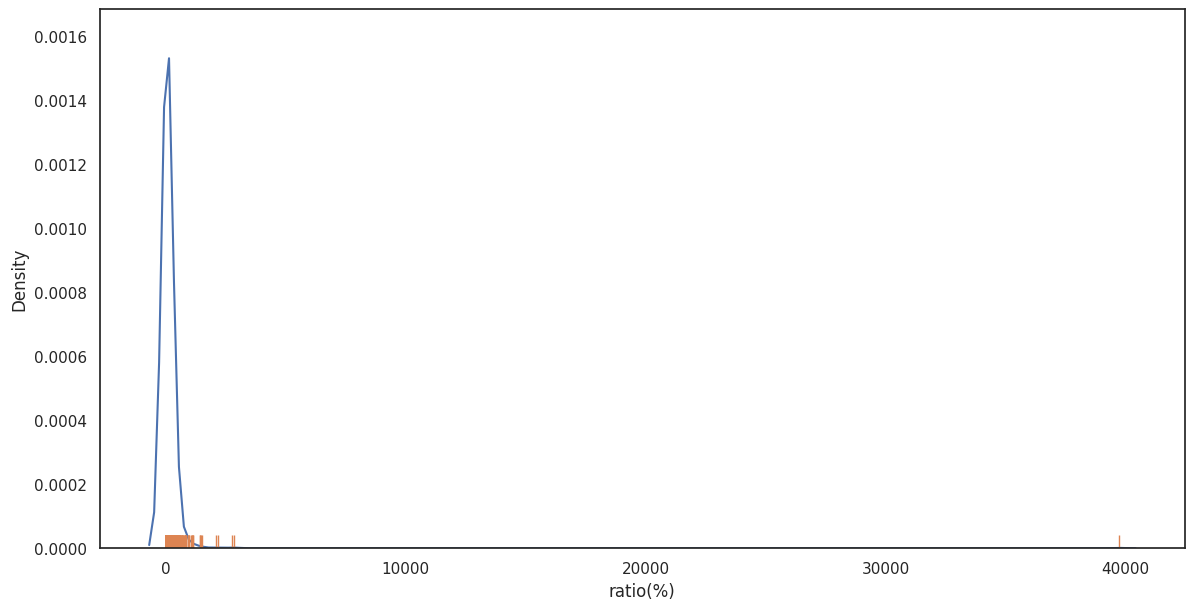

In [27]:
fig = plt.subplots(figsize=(14, 7))
sns.kdeplot(result["ratio(%)"])
sns.rugplot(result["ratio(%)"])

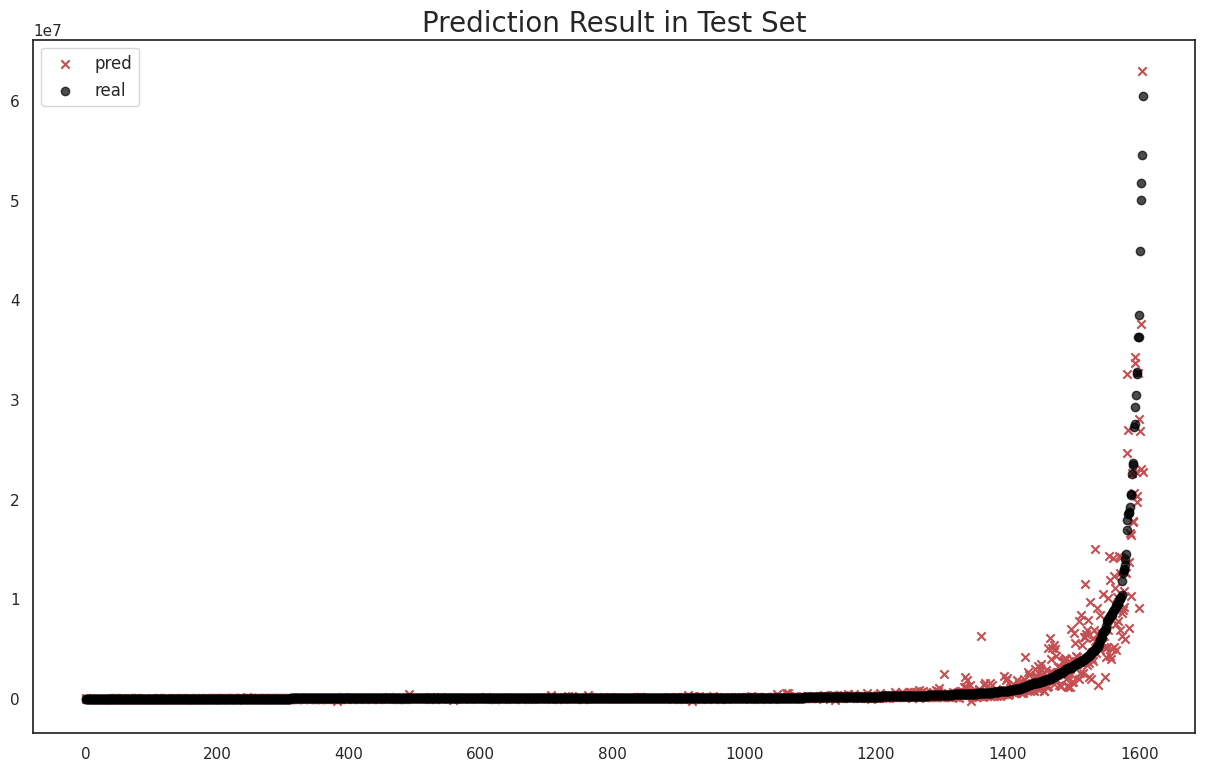

In [28]:
result = result.sort_values(by='real').reset_index(drop=True)

plt.figure(figsize=(15, 9))
plt.scatter(result.index, result['pred'], marker='x', color='r')
plt.scatter(result.index, result['real'], alpha=0.7, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['pred', 'real'], fontsize=12)
plt.show()

## **Model Save**

In [29]:
model.save_model("../Models/xgboost_model.json")